# **Model Training**



## **1. Project Setup**

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 

import sys
import os

# Add the module's parent directory to sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [ ]:
from lcz_classification.config import *
from lcz_classification.util import read_lcz_legend, normalize_arr
import rioxarray as rio

import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gpd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, recall_score,precision_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt



## 1.2 Setup Paths

In [3]:
## WORFLOW PARAMETERS

## USER INPUT ##
# ===============================================================================================================================================================

SENT2_DIR =f"{EXTERNAL}/sentinel2"
S2_FILE_PATH=f"../data/processed/sentinel2/resampled/s2_20210714_{CELL_RESOLUTION}m.tif"


# Select Sentinel-2 Bands
SENT2_BANDS=["B02", "B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12"] #Sentinel-2, bands from B02 to B07, B8A, B11, and B12 (provided at 20 m spatial resolution by Copernicus) are exploited.


## PROJECT CONFIGURATION ##
# ===============================================================================================================================================================


LCZ_CLASSES=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'A', 'B', 'C', 'D', 'E', 'F', 'G']


# Establish Study Area bounds
STUDY_AREA_GDF=gpd.read_file(f"{STUDY_AREA}/study_area.geojson")
STUDY_AREA_GDF=STUDY_AREA_GDF.to_crs(STUDY_AREA_GDF.estimate_utm_crs())

# Create Bounding Box Polygon
BBOX=box(*list(STUDY_AREA_GDF.total_bounds))
BBOX= BBOX.buffer(15, join_style=2) # Create 15 meter buffer for bounding box

# Retrieve CRS Based on bounds of study area
CRS=STUDY_AREA_GDF.estimate_utm_crs() # NAD83 / UTM zone 9N


LCZ_LEGEND, COLOR_DICT=read_lcz_legend(LCZ_LEGEND_FP)
label_dict=LCZ_LEGEND.set_index("class")["name"].to_dict()

GRID_SEARCH = True

### Load Data

In [4]:
s2=rio.open_rasterio(S2_FILE_PATH)

## URBAN CANOPY PARAMETERS ##
bh=rio.open_rasterio(BH_FP) # Building Height
ch=rio.open_rasterio(CH_FP) # Tree Canopy Height
isf=rio.open_rasterio(IS_FP) # Impervious Surface Fraction
bsf=rio.open_rasterio(BS_FP) # Building Surface Fraction
svf=rio.open_rasterio(SF_FP).rio.reproject_match(s2.sel(band=1)) # Building Surface Fraction


lcz=rio.open_rasterio(LCZ_FP) # Local Climate Zones Rasterized (Target Layer)

features=eval(s2.attrs['bands'])
features.extend(['Building Height', 'Canopy Height', 'Impervious Surface Fraction', 'Building Surface Fraction', 'Sky View Factor'])

s2 = s2 / 10000
s2_arr = s2.values
X_data=np.append(s2_arr,bh.fillna(0).values, axis=0)
X_data=np.append(X_data,ch.fillna(0).values, axis=0)
X_data=np.append(X_data,isf.fillna(0).values, axis=0)
X_data=np.append(X_data,bsf.fillna(0).values, axis=0)
X_data=np.append(X_data,svf.fillna(0).values, axis=0)



scaler=MinMaxScaler()

X= np.array([normalize_arr(x, scaler) for x in X_data])
# X=X.reshape(-1, X.shape[0])  # shape becomes (512*512, 10)
train_data=np.append(X,lcz.values, axis =0)

# condition=((lcz>0) & (lcz!=11)).values[0]
condition=(lcz>0).values[0]
train_data_filtered=np.array([arr[condition] for arr in train_data])


# X=np.array(train_data_filtered[0:-1]).reshape(-1,X_data.shape[0])
# y=train_data_filtered[-1].reshape(-1)
# y=np.int16(y)

cols=features.copy()
cols.append("lcz")

train_df=pd.DataFrame(train_data_filtered).T.dropna()
train_df.columns=cols
clean_df=train_df[~train_df.isna()]

clean_df[features]
X=clean_df[features].values.reshape(-1,X.shape[0])
y = clean_df['lcz'].values.reshape(-1)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)



labels=[label_dict[x] for x in np.int16(np.unique(y))]


## Train RandomForest Classifier

In [5]:
# from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
# # from sklearn.metrics import plot_confusion_matrix


# cl = RandomForestClassifier(n_estimators=150,random_state=42, n_jobs=-1)

# cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # scoring=('f1', 'recall', 'precision')

# scoring = {
#     'f1': make_scorer(f1_score, average='weighted'),
#     'recall': make_scorer(recall_score, average='weighted'),
#     'precision': make_scorer(precision_score, average='weighted')
# }
# scores=cross_validate(cl,X_train,y_train,scoring=scoring,cv=5, return_train_score=True)

# #Get average evaluation metrics
# print('Mean f1: %.3f' % np.mean(scores['test_f1']))
# print('Mean recall: %.3f' % np.mean(scores['test_recall']))
# print('Mean precision: %.3f' % np.mean(scores['test_precision']))



In [6]:
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2'],
#     'class_weight': ['balanced', None]
# }
# cl = RandomForestClassifier(random_state=42, n_jobs=-1)

# scoring = {
#     'f1': make_scorer(f1_score),
#     'recall': make_scorer(recall_score),
#     'precision': make_scorer(precision_score)
# }
# random_search=RandomizedSearchCV(cl, param_grid,scoring='accuracy', cv=5, return_train_score=True)
# random_search.fit(X_train, y_train)


In [7]:


# from sklearn.model_selection import learning_curve, LearningCurveDisplay
# from sklearn.model_selection import ShuffleSplit
# import numpy as np

# train_sizes, train_scores, test_scores = learning_curve(
#     cl, X, y, cv=5, scoring='accuracy',
#     train_sizes=np.linspace(0.1, 1.0, 5),
  
# )
# import matplotlib.pyplot as plt

# plt.figure(figsize=(6,4))

# plt.plot(train_sizes,train_scores.mean(axis=1))
# plt.plot(train_sizes,test_scores.mean(axis=1))

# plt.xlabel('Train Size')
# plt.ylabel('Accuracy Score')


In [8]:

GRID_SEARCH=False
if GRID_SEARCH:
    cl = RandomForestClassifier(random_state=42, n_jobs=-1)


    param_grid = {
        'n_estimators': [100, 150, 200, 500, 750, 1000], #[100, 150, 200, 500]
        'max_features': ['sqrt', 'log2'], #['auto', 'sqrt', 'log2']
        'criterion': ['gini', 'entropy'] #['gini', 'entropy']
    }
    grid_search=GridSearchCV(cl, param_grid, scoring='accuracy', cv=5,verbose=10, n_jobs=-1)
    grid_search.fit(X_train,y_train)

    best_params=grid_search.best_params_
    print(best_params)

    cl=RandomForestClassifier(random_state=42,n_jobs=-1, **best_params)


else:
    cl = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500)

cl.feature_names_in_ = np.array(features)
cl.classes_ = np.array(labels)

cl.fit(X_train,y_train)
y_pred=cl.predict(X_test)

## Classification Report

In [33]:
print(classification_report(y_test,y_pred,digits=3,target_names=labels))

                   precision    recall  f1-score   support

Compact High-Rise      0.876     0.801     0.837       352
   Open High-Rise      0.726     0.390     0.507       136
    Open Low-Rise      0.876     0.928     0.901       594
   Large low-rise      0.908     0.966     0.936       903
      Dense trees      0.996     1.000     0.998       278
            Water      1.000     1.000     1.000      1741

         accuracy                          0.943      4004
        macro avg      0.897     0.847     0.863      4004
     weighted avg      0.940     0.943     0.940      4004



## Confusion Matrix

In [1]:


cm=confusion_matrix(y_test,y_pred)
cm_p=(cm / len(y_test)) * 100


mask = cm_p == 0.0

plt.figure(figsize=(10,8))

# sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues',
#             xticklabels=labels, yticklabels=labels, mask=mask,
#             )

sns.heatmap(cm_p, annot=True, fmt=".1f", cmap='Blues',
            xticklabels=labels, yticklabels=labels, mask=mask,
            )

plt.xlabel("True",  fontdict=dict(size = 20, weight ='bold'))
plt.ylabel("Predicted",  fontdict=dict(size = 20, weight ='bold'))
plt.title('Confusion Matrix of LCZ Trainning Areas on Sentinel-2', fontdict=dict(size = 20, weight ='bold'))

NameError: name 'confusion_matrix' is not defined

Elapsed time to compute the importances: 0.126 seconds


C:\Users\medo_\AppData\Local\Temp\ipykernel_5716\3739996771.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')


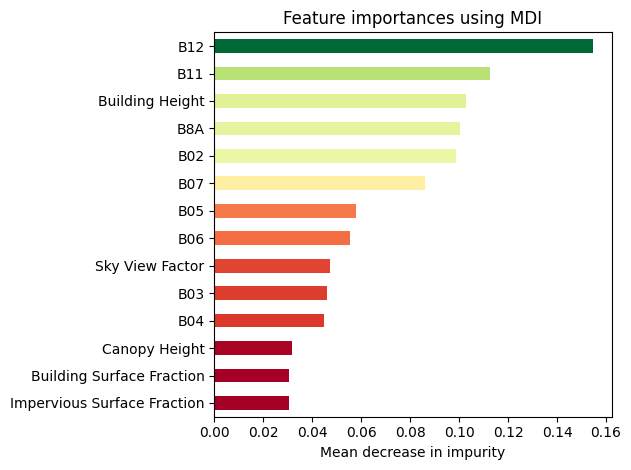

In [21]:
import pandas as pd

import time

import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

start_time = time.time()
importances = cl.feature_importances_
std = np.std([tree.feature_importances_ for tree in cl.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

rf_i = pd.Series(cl.feature_importances_, index=features).sort_values()

# Choose a colormap (e.g., 'viridis', 'plasma', 'coolwarm', etc.)
cmap = cm.get_cmap('RdYlGn')

# Normalize the series to the range 0-1
norm = colors.Normalize(vmin=rf_i.min(), vmax=rf_i.max())

# Map each value to a color
rgba_colors = [cmap(norm(val)) for val in rf_i]
hex_colors = [colors.to_hex(c) for c in rgba_colors]



fig, ax = plt.subplots()
rf_i.plot.barh(ax=ax, color=hex_colors)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()